<a href="https://colab.research.google.com/github/phaneendra5363/GCPTFClusterCreation/blob/main/Homework_7_Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Set 7
In this problem set you will implement Newton's Method, and L-BFGS, a memory-efficient version of BFGS.

## Upload Data Files
Upload `BFGS.zip` and `digits.zip` to Colab before running the cells below.

In [1]:
# Upload files in Colab
from google.colab import files
uploaded = files.upload()  # Upload BFGS.zip and digits.zip

Saving BFGS.zip to BFGS.zip
Saving digits.zip to digits.zip


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import zipfile
import time

%matplotlib inline
np.random.seed(42)

---
# Problem 1: Newton's Method

Consider $f_m(x) = \|x\|^3 + \frac{m}{2}\|x\|^2$ for $m \in \{0, 0.0001, 0.001, 0.1\}$ and $x \in \mathbb{R}^5$.


## Part (A)
For each $m$, implement Newton's method on $f_m(x)$ and provide the convergence plots, i.e $\log(\|x^{(k)} - x^{\ast}\|^2)$ vs. iteration $k$. Use the constant step size $t=1$.

### Derivation of Gradient and Hessian

We have $f_m(x) = \|x\|^3 + \frac{m}{2}\|x\|^2$.

Let $r = \|x\| = \sqrt{x^\top x}$.

**Gradient:**

$$\nabla f_m(x) = 3\|x\| x + m x = (3\|x\| + m) x$$

**Hessian:**

$$\nabla^2 f_m(x) = 3\|x\| I + \frac{3}{\|x\|} x x^\top + m I = (3\|x\| + m) I + \frac{3}{\|x\|} x x^\top$$

Note: The optimum is $x^* = 0$ for all $m \geq 0$.

In [3]:
def f_m(x, m):
    """Compute f_m(x) = ||x||^3 + (m/2)||x||^2"""
    norm_x = np.linalg.norm(x)
    return norm_x**3 + (m / 2.0) * norm_x**2

def grad_f_m(x, m):
    """Gradient: (3||x|| + m) * x"""
    norm_x = np.linalg.norm(x)
    if norm_x < 1e-16:
        return np.zeros_like(x)
    return (3.0 * norm_x + m) * x

def hess_f_m(x, m):
    """Hessian: (3||x|| + m) I + (3/||x||) x x^T"""
    n = len(x)
    norm_x = np.linalg.norm(x)
    if norm_x < 1e-16:
        return m * np.eye(n)
    H = (3.0 * norm_x + m) * np.eye(n) + (3.0 / norm_x) * np.outer(x, x)
    return H

def newtons_method(x0, m, max_iter=200, tol=1e-15):
    """Newton's method with step size t=1."""
    x = x0.copy()
    x_star = np.zeros_like(x0)
    errors = [np.linalg.norm(x - x_star)**2]

    for k in range(max_iter):
        g = grad_f_m(x, m)
        H = hess_f_m(x, m)

        if np.linalg.norm(g) < tol:
            break

        try:
            delta = np.linalg.solve(H, -g)
        except np.linalg.LinAlgError:
            break

        x = x + delta  # step size t = 1
        err = np.linalg.norm(x - x_star)**2
        errors.append(err)

        if err < 1e-30:
            break

    return x, errors

<>:22: SyntaxWarning: invalid escape sequence '\|'
<>:22: SyntaxWarning: invalid escape sequence '\|'
/tmp/ipython-input-3800800968.py:22: SyntaxWarning: invalid escape sequence '\|'
  plt.suptitle("Newton's Method Convergence for $f_m(x) = \|x\|^3 + (m/2)\|x\|^2$", fontsize=14)


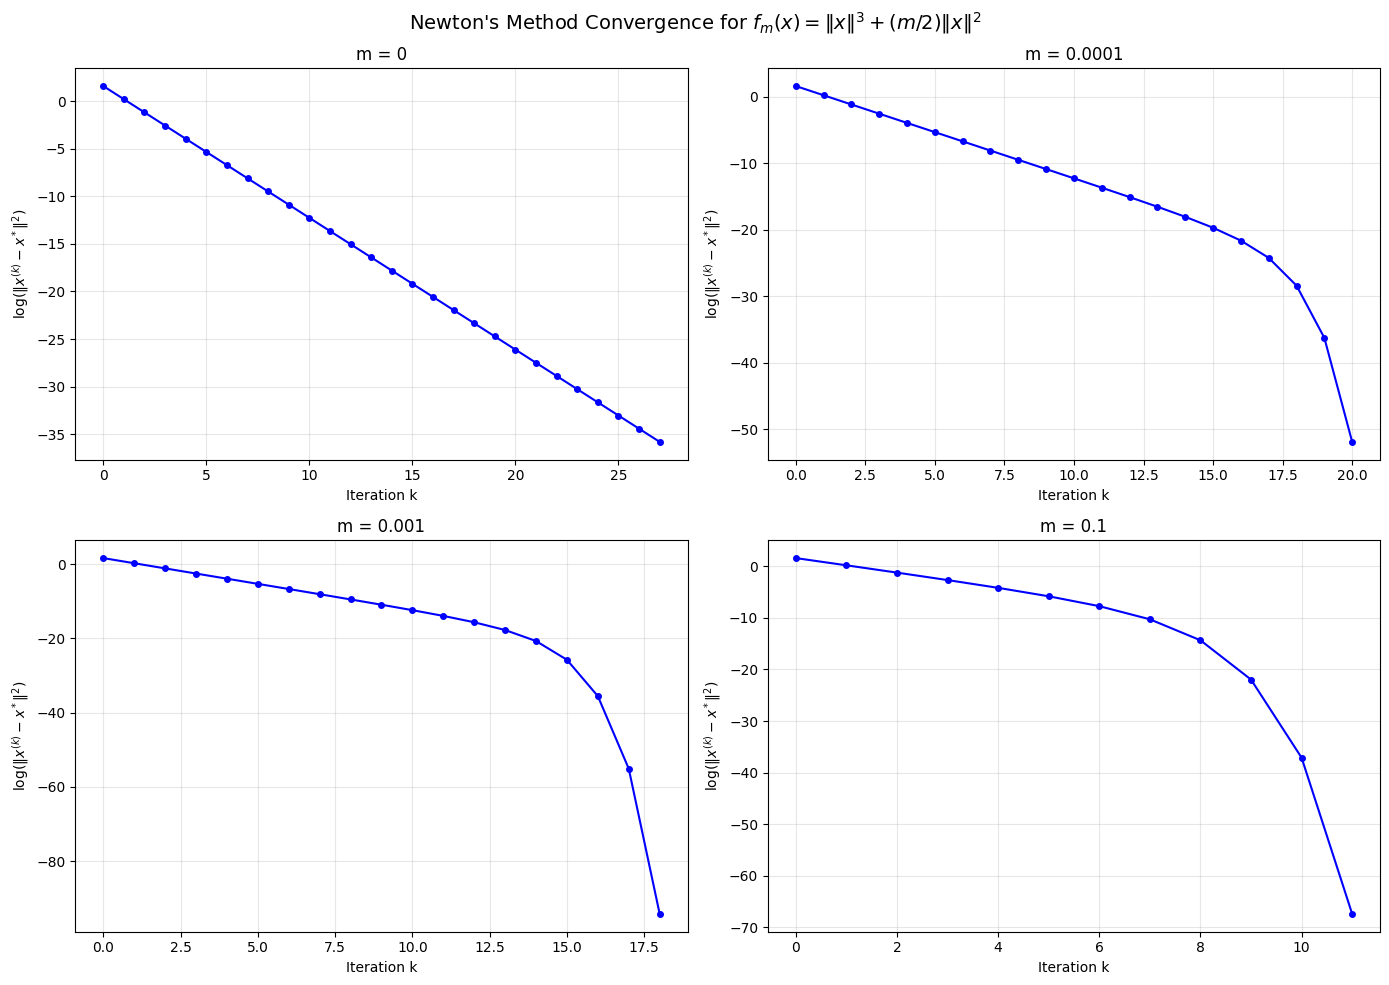

m = 0: converged in 27 iterations
m = 0.0001: converged in 20 iterations
m = 0.001: converged in 18 iterations
m = 0.1: converged in 11 iterations


In [4]:
# Run Newton's method for each m
m_values = [0, 0.0001, 0.001, 0.1]
x0 = np.ones(5)  # Initial point

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

all_errors = {}
for i, m in enumerate(m_values):
    x_sol, errors = newtons_method(x0.copy(), m, max_iter=200)
    all_errors[m] = errors

    # Filter out zeros for log plot
    log_errors = [np.log(e) if e > 0 else -70 for e in errors]

    axes[i].plot(range(len(log_errors)), log_errors, 'b-o', markersize=4)
    axes[i].set_xlabel('Iteration k')
    axes[i].set_ylabel(r'$\log(\|x^{(k)} - x^*\|^2)$')
    axes[i].set_title(f'm = {m}')
    axes[i].grid(True, alpha=0.3)

plt.suptitle("Newton's Method Convergence for $f_m(x) = \|x\|^3 + (m/2)\|x\|^2$", fontsize=14)
plt.tight_layout()
plt.show()

for m in m_values:
    print(f"m = {m}: converged in {len(all_errors[m])-1} iterations")

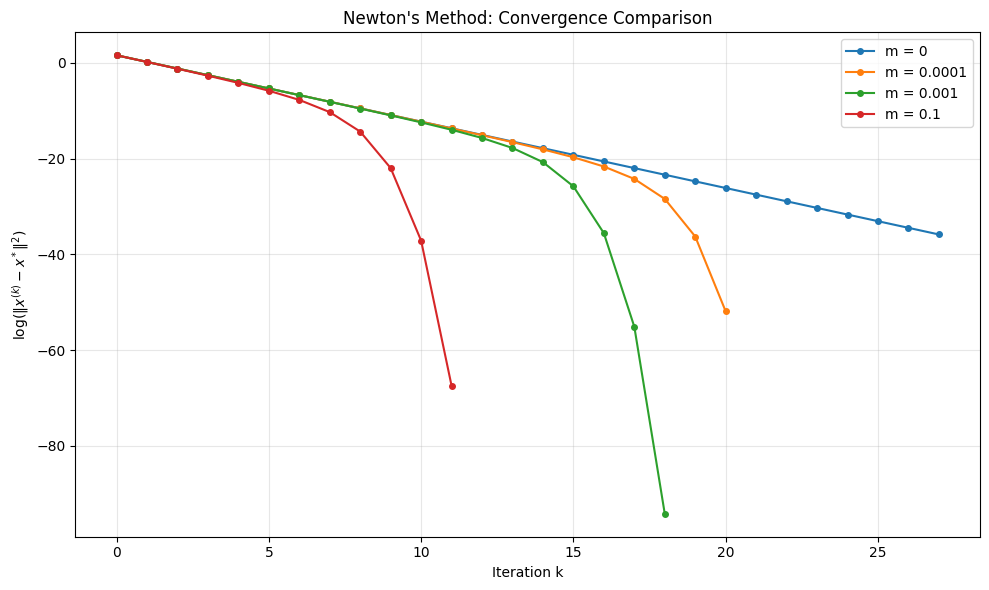

In [5]:
# Combined plot for comparison
plt.figure(figsize=(10, 6))
for m in m_values:
    errors = all_errors[m]
    log_errors = [np.log(e) if e > 0 else -70 for e in errors]
    plt.plot(range(len(log_errors)), log_errors, '-o', markersize=4, label=f'm = {m}')

plt.xlabel('Iteration k')
plt.ylabel(r'$\log(\|x^{(k)} - x^*\|^2)$')
plt.title("Newton's Method: Convergence Comparison")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Part (B): Explanation of Convergence Behavior

Newton's method achieves **quadratic convergence** when the Hessian $\nabla^2 f(x^*)$ at the optimum is **positive definite** (i.e., the function is strongly convex near the optimum). The relevant condition is:

$$\|x^{(k+1)} - x^*\| \leq C \|x^{(k)} - x^*\|^2$$

which requires the Hessian to be Lipschitz continuous and nonsingular at $x^*$.

**Analysis for different $m$:**

- **$m = 0$**: $\nabla^2 f_0(x^*) = 0$ at $x^* = 0$, so the Hessian is **singular** at the optimum. Newton's method cannot achieve quadratic convergence. Instead, we observe **damped (linear)** convergence because the strong convexity condition fails.

- **$m = 0.0001$**: $\nabla^2 f_m(x^*) = m I = 0.0001 I$ is positive definite but has a very small minimum eigenvalue. Quadratic convergence eventually kicks in, but only when $\|x^{(k)}\|$ is small enough that the $mI$ term dominates the $3\|x\|I$ term. Initially, convergence appears linear (damped phase), then transitions to quadratic.

- **$m = 0.001$**: Similar to $m = 0.0001$ but the transition to quadratic convergence happens sooner because the strong convexity constant is larger.

- **$m = 0.1$**: $\nabla^2 f_m(x^*) = 0.1 I$ has a reasonably large minimum eigenvalue. Quadratic convergence is observed almost immediately, and the method converges very quickly.

**In summary:** As $m$ increases, the Hessian at the optimum becomes better conditioned (larger minimum eigenvalue), and Newton's method transitions from damped/linear convergence ($m=0$) to rapid quadratic convergence ($m=0.1$). This perfectly illustrates the theoretical requirement that the Hessian must be nonsingular at the optimum for quadratic convergence.

---
# Problem 2: BFGS

Use BFGS to solve the two quadratic problems: $0.5x^\top M_i x - b_i^\top x$ for $i \in \{1,2\}$.

For quadratic problems, we use an **exact line search**.

In [6]:
# Load BFGS data
def loaddata_bfgs(filename):
    data = {}
    with zipfile.ZipFile(filename) as z:
        for fname in z.namelist():
            if 'MAC' in fname or fname.endswith('/'):
                continue
            # Extract just the filename part (handle nested directories)
            base = fname.split('/')[-1]
            if base.endswith('.csv'):
                data[base] = pd.read_csv(z.open(fname), sep=',', header=None)
    return data

bfgs_dict = loaddata_bfgs('./BFGS.zip')
print('Keys:', bfgs_dict.keys())

b1 = bfgs_dict['b1.csv'].values.flatten()
b2 = bfgs_dict['b2.csv'].values.flatten()
M1 = bfgs_dict['M1.csv'].values
M2 = bfgs_dict['M2.csv'].values
x_star_bfgs = bfgs_dict['x.csv'].values.flatten()

print(f"M1 shape: {M1.shape}, b1 shape: {b1.shape}")
print(f"M2 shape: {M2.shape}, b2 shape: {b2.shape}")
print(f"x* shape: {x_star_bfgs.shape}")

Keys: dict_keys(['b1.csv', 'b2.csv', 'M1.csv', 'M2.csv', 'x.csv'])
M1 shape: (1000, 1000), b1 shape: (1000,)
M2 shape: (1000, 1000), b2 shape: (1000,)
x* shape: (1000,)


In [7]:
def quadratic_f(x, M, b):
    """f(x) = 0.5 x^T M x - b^T x"""
    return 0.5 * x @ M @ x - b @ x

def quadratic_grad(x, M, b):
    """grad f(x) = M x - b"""
    return M @ x - b

def exact_line_search_quadratic(x, d, M, b):
    """
    Exact line search for quadratic: f(x + t*d)
    t* = -(grad^T d) / (d^T M d)
    """
    g = quadratic_grad(x, M, b)
    dMd = d @ M @ d
    if abs(dMd) < 1e-30:
        return 0.0
    return -(g @ d) / dMd

def bfgs_quadratic(M, b, x0, max_iter=500, tol=1e-12):
    """
    BFGS for quadratic problems with exact line search.
    Returns iterates and errors.
    """
    n = len(x0)
    x = x0.copy()
    H = np.eye(n)  # Initial inverse Hessian approximation
    x_star = np.linalg.solve(M, b)  # Exact solution: Mx* = b

    # M-norm error: ||x - x*||_M^2 = (x-x*)^T M (x-x*)
    diff = x - x_star
    errors = [diff @ M @ diff]

    g = quadratic_grad(x, M, b)

    for k in range(max_iter):
        if np.linalg.norm(g) < tol:
            break

        # Search direction
        d = -H @ g

        # Exact line search
        t = exact_line_search_quadratic(x, d, M, b)

        # Update x
        s = t * d
        x_new = x + s

        # New gradient
        g_new = quadratic_grad(x_new, M, b)
        y = g_new - g

        # BFGS update of inverse Hessian approximation H
        sy = s @ y
        if abs(sy) > 1e-30:
            rho = 1.0 / sy
            I = np.eye(n)
            V = I - rho * np.outer(s, y)
            H = V @ H @ V.T + rho * np.outer(s, s)

        x = x_new
        g = g_new

        diff = x - x_star
        err = diff @ M @ diff
        errors.append(err)

        if err < 1e-30:
            break

    return x, errors

Problem 1: converged in 500 iterations
Problem 2: converged in 500 iterations


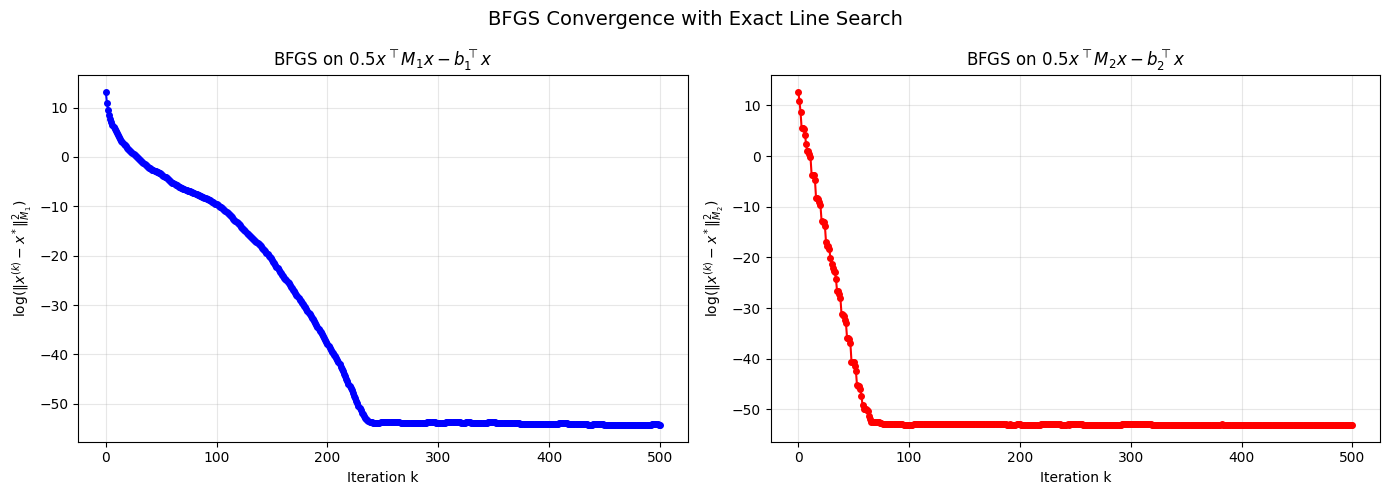

In [8]:
# Run BFGS on both quadratic problems
n = M1.shape[0]
x0 = np.zeros(n)

x_sol1, errors1 = bfgs_quadratic(M1, b1, x0)
x_sol2, errors2 = bfgs_quadratic(M2, b2, x0)

print(f"Problem 1: converged in {len(errors1)-1} iterations")
print(f"Problem 2: converged in {len(errors2)-1} iterations")

# Plot convergence
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

log_err1 = [np.log(e) if e > 0 else -70 for e in errors1]
log_err2 = [np.log(e) if e > 0 else -70 for e in errors2]

axes[0].plot(range(len(log_err1)), log_err1, 'b-o', markersize=4)
axes[0].set_xlabel('Iteration k')
axes[0].set_ylabel(r'$\log(\|x^{(k)} - x^*\|_{M_1}^2)$')
axes[0].set_title('BFGS on $0.5x^\\top M_1 x - b_1^\\top x$')
axes[0].grid(True, alpha=0.3)

axes[1].plot(range(len(log_err2)), log_err2, 'r-o', markersize=4)
axes[1].set_xlabel('Iteration k')
axes[1].set_ylabel(r'$\log(\|x^{(k)} - x^*\|_{M_2}^2)$')
axes[1].set_title('BFGS on $0.5x^\\top M_2 x - b_2^\\top x$')
axes[1].grid(True, alpha=0.3)

plt.suptitle('BFGS Convergence with Exact Line Search', fontsize=14)
plt.tight_layout()
plt.show()

**Observation:** For quadratic problems, BFGS with exact line search converges in at most $n$ iterations (where $n$ is the dimension), since the inverse Hessian approximation $H_k$ converges to the exact inverse Hessian $M^{-1}$ in finite steps for quadratic objectives. This is analogous to conjugate gradient achieving finite convergence on quadratics.

---
# Problem 3: BFGS on Digits Dataset

Multiclass logistic regression: minimize the negative log-likelihood

$$\min_\mathbf{b} \ell(\mathbf{b}) = \sum_{i=1}^N \left( b_{y_i}^\top x_i + \log{\sum_{j=1}^C e^{-b_j^\top x_i}} \right)$$

In [10]:
# Load digits data
def loaddata_digits(filename):
    data = {}
    with zipfile.ZipFile(filename) as z:
        for fname in z.namelist():
            # Skip directories and macOS metadata files
            if fname.endswith('/') or '__MACOSX' in fname or 'MAC' in fname or fname.startswith('.'):
                continue
            base = fname.split('/')[-1]
            if base.endswith('.csv'):
                try:
                    data[base] = pd.read_csv(z.open(fname), sep=' ', header=None, encoding='utf-8')
                except UnicodeDecodeError:
                    data[base] = pd.read_csv(z.open(fname), sep=' ', header=None, encoding='latin-1')
    return data

digits_dict = loaddata_digits('./digits.zip')
print('Keys:', digits_dict.keys())

X_train = digits_dict['X_digits_train.csv'].values
X_test = digits_dict['X_digits_test.csv'].values
y_train = digits_dict['y_digits_train.csv'].values.flatten().astype(int)
y_test = digits_dict['y_digits_test.csv'].values.flatten().astype(int)

print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")
print(f"Classes: {np.unique(y_train)}")

Keys: dict_keys(['X_digits_train.csv', 'y_digits_train.csv', 'X_digits_test.csv', 'y_digits_test.csv'])
X_train: (1198, 64), y_train: (1198,)
X_test: (599, 64), y_test: (599,)
Classes: [0 1 2 3 4 5 6 7 8 9]


In [11]:
# Logistic regression functions

def softmax(scores):
    """Compute softmax probabilities. scores: (N, C)"""
    # Use negative scores since our formulation uses e^{-b_j^T x_i}
    shifted = scores - np.max(scores, axis=1, keepdims=True)  # for numerical stability
    exp_scores = np.exp(shifted)
    return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

def neg_log_likelihood(B, X, y, C):
    """
    Negative log-likelihood for multiclass logistic regression.
    B: (d*C,) flattened parameter vector
    X: (N, d) feature matrix
    y: (N,) labels in {0, 1, ..., C-1}

    Using the formulation:
    ell(b) = sum_i [ b_{y_i}^T x_i + log(sum_j exp(-b_j^T x_i)) ]

    Which is equivalent to standard cross-entropy with sign flips.
    We use the standard softmax formulation for easier implementation:
    ell(b) = -sum_i [ -b_{y_i}^T x_i - log(sum_j exp(-b_j^T x_i)) ]
           = -sum_i log( exp(-b_{y_i}^T x_i) / sum_j exp(-b_j^T x_i) )
    """
    N, d = X.shape
    B_mat = B.reshape(C, d)  # (C, d)

    # Scores: -B @ X^T -> (C, N), then transpose to (N, C)
    scores = -X @ B_mat.T  # (N, C): score[i,j] = -b_j^T x_i

    # Softmax probabilities p[i,j] = exp(-b_j^T x_i) / sum_k exp(-b_k^T x_i)
    probs = softmax(scores)  # (N, C)

    # NLL = -sum_i log(p[i, y_i])
    log_probs = np.log(probs[np.arange(N), y] + 1e-15)
    nll = -np.sum(log_probs)
    return nll

def neg_log_likelihood_grad(B, X, y, C):
    """
    Gradient of NLL w.r.t. B.

    grad w.r.t. b_j = sum_i (p(j|x_i) - 1{y_i=j}) * (-x_i)

    In matrix form:
    grad_B_mat = -(P - Y_onehot)^T @ X
    where P[i,j] = softmax prob, Y_onehot[i,j] = 1{y_i=j}
    """
    N, d = X.shape
    B_mat = B.reshape(C, d)

    scores = -X @ B_mat.T  # (N, C)
    probs = softmax(scores)  # (N, C)

    # One-hot encoding
    Y_oh = np.zeros((N, C))
    Y_oh[np.arange(N), y] = 1.0

    # Gradient: for the formulation with -b_j^T x_i
    # d/d(b_j) = sum_i (p[i,j] - Y_oh[i,j]) * (-x_i)
    grad_B_mat = -(probs - Y_oh).T @ X  # (C, d)

    return grad_B_mat.flatten()

def predict(B, X, C):
    """Predict class labels."""
    d = X.shape[1]
    B_mat = B.reshape(C, d)
    scores = -X @ B_mat.T  # (N, C)
    return np.argmax(scores, axis=1)

def accuracy(B, X, y, C):
    """Compute classification accuracy."""
    preds = predict(B, X, C)
    return np.mean(preds == y)

In [12]:
# Wolfe line search for BFGS on non-quadratic problems

def wolfe_line_search(f, grad_f, x, d, c1=1e-4, c2=0.9, max_ls=30):
    """
    Backtracking line search satisfying Armijo condition.
    """
    t = 1.0
    fx = f(x)
    gx = grad_f(x)
    slope = gx @ d

    for _ in range(max_ls):
        if f(x + t * d) <= fx + c1 * t * slope:
            break
        t *= 0.5

    return t

def bfgs_logistic(X, y, C, max_iter=200, tol=1e-6):
    """
    BFGS for multiclass logistic regression.
    """
    N, d = X.shape
    p = C * d  # total number of parameters
    B = np.zeros(p)
    H = np.eye(p)  # Initial inverse Hessian approximation

    f = lambda b: neg_log_likelihood(b, X, y, C)
    grad_f = lambda b: neg_log_likelihood_grad(b, X, y, C)

    losses = [f(B)]
    g = grad_f(B)

    for k in range(max_iter):
        if np.linalg.norm(g) < tol:
            print(f"Converged at iteration {k}")
            break

        # Search direction
        d = -H @ g

        # Line search
        t = wolfe_line_search(f, grad_f, B, d)

        # Update
        s = t * d
        B_new = B + s
        g_new = grad_f(B_new)
        y_diff = g_new - g

        # BFGS update
        sy = s @ y_diff
        if sy > 1e-10:
            rho = 1.0 / sy
            I = np.eye(p)
            V = I - rho * np.outer(s, y_diff)
            H = V @ H @ V.T + rho * np.outer(s, s)

        B = B_new
        g = g_new

        loss = f(B)
        losses.append(loss)

        if (k + 1) % 20 == 0:
            print(f"Iter {k+1}: loss = {loss:.4f}, ||grad|| = {np.linalg.norm(g):.6f}")

    return B, losses

In [13]:
# Run BFGS on digits dataset
C = len(np.unique(y_train))
print(f"Number of classes: {C}")
print(f"Feature dimension: {X_train.shape[1]}")
print(f"Parameter dimension: {C * X_train.shape[1]}")

B_opt, train_losses = bfgs_logistic(X_train, y_train, C, max_iter=200)

# Compute test loss at each iteration (re-run tracking test loss)
train_acc = accuracy(B_opt, X_train, y_train, C)
test_acc = accuracy(B_opt, X_test, y_test, C)
print(f"\nFinal train accuracy: {train_acc:.4f}")
print(f"Final test accuracy: {test_acc:.4f}")

Number of classes: 10
Feature dimension: 64
Parameter dimension: 640
Iter 20: loss = 23.5690, ||grad|| = 210.232635
Iter 40: loss = 0.5076, ||grad|| = 8.465220
Iter 60: loss = 0.1133, ||grad|| = 1.111427
Iter 80: loss = 0.0423, ||grad|| = 0.292418
Iter 100: loss = 0.0262, ||grad|| = 0.165600
Iter 120: loss = 0.0181, ||grad|| = 0.111840
Iter 140: loss = 0.0140, ||grad|| = 0.095083
Iter 160: loss = 0.0111, ||grad|| = 0.060676
Iter 180: loss = 0.0091, ||grad|| = 0.030890
Iter 200: loss = 0.0077, ||grad|| = 0.024525

Final train accuracy: 1.0000
Final test accuracy: 0.9482


<>:6: SyntaxWarning: invalid escape sequence '\e'
<>:13: SyntaxWarning: invalid escape sequence '\l'
<>:6: SyntaxWarning: invalid escape sequence '\e'
<>:13: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipython-input-2309649992.py:6: SyntaxWarning: invalid escape sequence '\e'
  axes[0].set_ylabel('Training Loss $\ell(b)$')
/tmp/ipython-input-2309649992.py:13: SyntaxWarning: invalid escape sequence '\l'
  axes[1].set_ylabel('$\log(\ell(b))$')


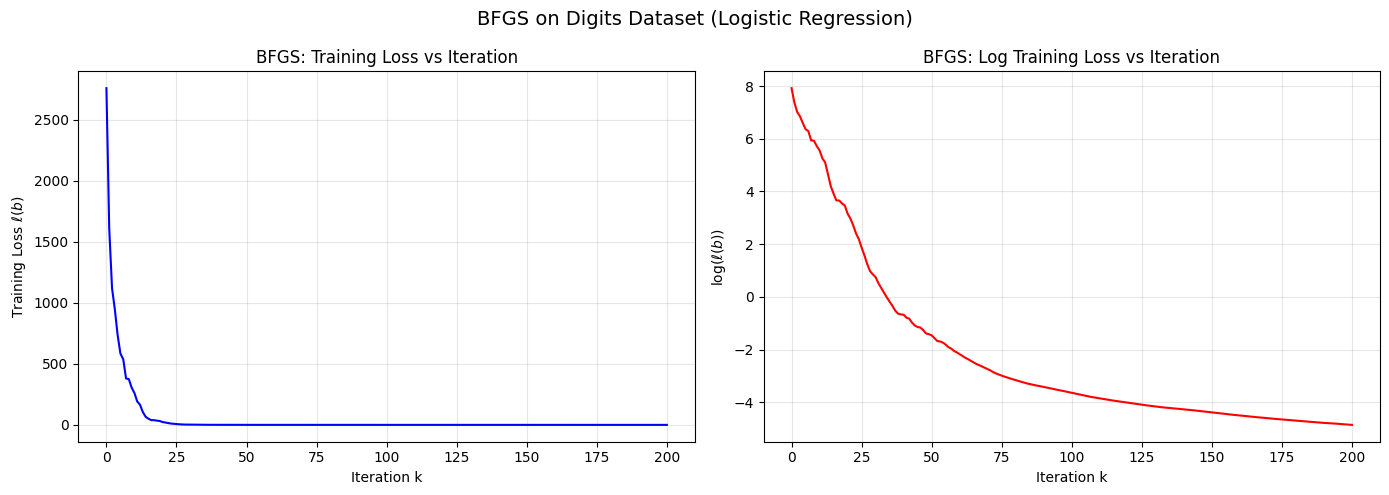

In [14]:
# Plot training loss
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(train_losses, 'b-', linewidth=1.5)
axes[0].set_xlabel('Iteration k')
axes[0].set_ylabel('Training Loss $\ell(b)$')
axes[0].set_title('BFGS: Training Loss vs Iteration')
axes[0].grid(True, alpha=0.3)

log_losses = [np.log(l) if l > 0 else -70 for l in train_losses]
axes[1].plot(log_losses, 'r-', linewidth=1.5)
axes[1].set_xlabel('Iteration k')
axes[1].set_ylabel('$\log(\ell(b))$')
axes[1].set_title('BFGS: Log Training Loss vs Iteration')
axes[1].grid(True, alpha=0.3)

plt.suptitle('BFGS on Digits Dataset (Logistic Regression)', fontsize=14)
plt.tight_layout()
plt.show()

---
# Problem 4: L-BFGS (Optional)

L-BFGS is a memory-efficient version of BFGS that stores only the last $m$ updates (pairs $(s_k, y_k)$) instead of the full $n \times n$ inverse Hessian approximation.

In [15]:
def lbfgs_two_loop(g, s_hist, y_hist):
    """
    L-BFGS two-loop recursion to compute H_k @ g.
    s_hist: list of s_k vectors
    y_hist: list of y_k vectors
    Returns: H_k @ g (the search direction is -result)
    """
    q = g.copy()
    m = len(s_hist)
    alphas = np.zeros(m)
    rhos = np.zeros(m)

    for i in range(m - 1, -1, -1):
        rhos[i] = 1.0 / (y_hist[i] @ s_hist[i])
        alphas[i] = rhos[i] * (s_hist[i] @ q)
        q = q - alphas[i] * y_hist[i]

    # Initial Hessian approximation: gamma_k * I
    if m > 0:
        gamma = (s_hist[-1] @ y_hist[-1]) / (y_hist[-1] @ y_hist[-1])
    else:
        gamma = 1.0
    r = gamma * q

    for i in range(m):
        beta = rhos[i] * (y_hist[i] @ r)
        r = r + (alphas[i] - beta) * s_hist[i]

    return r

def lbfgs_logistic(X, y, C, memory_size=10, max_iter=200, tol=1e-6):
    """
    L-BFGS for multiclass logistic regression.
    """
    N, d = X.shape
    p = C * d
    B = np.zeros(p)

    f = lambda b: neg_log_likelihood(b, X, y, C)
    grad_f = lambda b: neg_log_likelihood_grad(b, X, y, C)

    s_hist = []
    y_hist = []

    losses = [f(B)]
    times = [0.0]
    g = grad_f(B)
    start_time = time.time()

    for k in range(max_iter):
        if np.linalg.norm(g) < tol:
            print(f"L-BFGS (m={memory_size}): Converged at iteration {k}")
            break

        # Compute direction using two-loop recursion
        Hg = lbfgs_two_loop(g, s_hist, y_hist)
        d_dir = -Hg

        # Line search
        t = wolfe_line_search(f, grad_f, B, d_dir)

        s = t * d_dir
        B_new = B + s
        g_new = grad_f(B_new)
        y_diff = g_new - g

        # Store history
        if s @ y_diff > 1e-10:
            if len(s_hist) >= memory_size:
                s_hist.pop(0)
                y_hist.pop(0)
            s_hist.append(s.copy())
            y_hist.append(y_diff.copy())

        B = B_new
        g = g_new

        loss = f(B)
        losses.append(loss)
        times.append(time.time() - start_time)

        if (k + 1) % 50 == 0:
            print(f"L-BFGS (m={memory_size}) Iter {k+1}: loss = {loss:.4f}")

    return B, losses, times

In [16]:
# Run L-BFGS with different memory sizes and compare with BFGS
memory_sizes = [3, 5, 10, 20]

# BFGS with timing
print("Running BFGS...")
start = time.time()
f_bfgs = lambda b: neg_log_likelihood(b, X_train, y_train, C)

# Re-run BFGS with timing
N, d = X_train.shape
p = C * d
B = np.zeros(p)
H = np.eye(p)
grad_f_bfgs = lambda b: neg_log_likelihood_grad(b, X_train, y_train, C)
bfgs_losses = [f_bfgs(B)]
bfgs_times = [0.0]
g = grad_f_bfgs(B)
start_bfgs = time.time()

for k in range(200):
    if np.linalg.norm(g) < 1e-6:
        break
    d_dir = -H @ g
    t = wolfe_line_search(f_bfgs, grad_f_bfgs, B, d_dir)
    s = t * d_dir
    B_new = B + s
    g_new = grad_f_bfgs(B_new)
    y_diff = g_new - g
    sy = s @ y_diff
    if sy > 1e-10:
        rho = 1.0 / sy
        I = np.eye(p)
        V = I - rho * np.outer(s, y_diff)
        H = V @ H @ V.T + rho * np.outer(s, s)
    B = B_new
    g = g_new
    bfgs_losses.append(f_bfgs(B))
    bfgs_times.append(time.time() - start_bfgs)

print(f"BFGS: {len(bfgs_losses)-1} iterations, {bfgs_times[-1]:.2f}s")

# L-BFGS for different memory sizes
lbfgs_results = {}
for m_size in memory_sizes:
    print(f"\nRunning L-BFGS (m={m_size})...")
    B_lbfgs, losses, times = lbfgs_logistic(X_train, y_train, C, memory_size=m_size, max_iter=200)
    lbfgs_results[m_size] = (losses, times)
    acc = accuracy(B_lbfgs, X_test, y_test, C)
    print(f"L-BFGS (m={m_size}): {len(losses)-1} iters, {times[-1]:.2f}s, test acc: {acc:.4f}")

Running BFGS...
BFGS: 200 iterations, 11.08s

Running L-BFGS (m=3)...
L-BFGS (m=3) Iter 50: loss = 13.1990
L-BFGS (m=3) Iter 100: loss = 0.0435
L-BFGS (m=3): Converged at iteration 122
L-BFGS (m=3): 122 iters, 0.60s, test acc: 0.9499

Running L-BFGS (m=5)...
L-BFGS (m=5) Iter 50: loss = 9.0212
L-BFGS (m=5) Iter 100: loss = 0.0000
L-BFGS (m=5): Converged at iteration 100
L-BFGS (m=5): 100 iters, 0.53s, test acc: 0.9499

Running L-BFGS (m=10)...
L-BFGS (m=10) Iter 50: loss = 2.9624
L-BFGS (m=10): Converged at iteration 82
L-BFGS (m=10): 82 iters, 0.42s, test acc: 0.9566

Running L-BFGS (m=20)...
L-BFGS (m=20) Iter 50: loss = 0.0500
L-BFGS (m=20): Converged at iteration 71
L-BFGS (m=20): 71 iters, 0.39s, test acc: 0.9516


<>:11: SyntaxWarning: invalid escape sequence '\e'
<>:22: SyntaxWarning: invalid escape sequence '\e'
<>:11: SyntaxWarning: invalid escape sequence '\e'
<>:22: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipython-input-1020885750.py:11: SyntaxWarning: invalid escape sequence '\e'
  axes[0].set_ylabel('Training Loss $\ell(b)$')
/tmp/ipython-input-1020885750.py:22: SyntaxWarning: invalid escape sequence '\e'
  axes[1].set_ylabel('Training Loss $\ell(b)$')


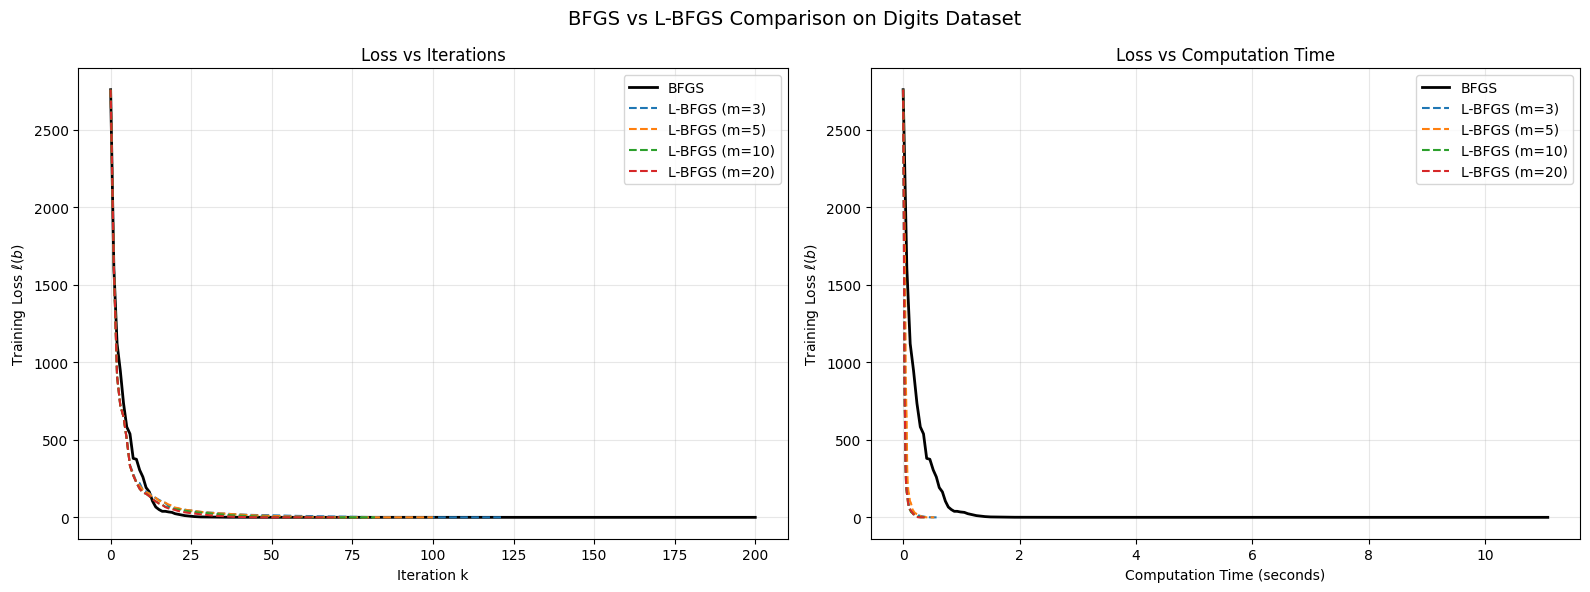

In [17]:
# Plot: Loss vs Iterations
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Loss vs Iteration
axes[0].plot(bfgs_losses, 'k-', linewidth=2, label='BFGS')
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
for i, m_size in enumerate(memory_sizes):
    losses, times = lbfgs_results[m_size]
    axes[0].plot(losses, color=colors[i], linestyle='--', linewidth=1.5, label=f'L-BFGS (m={m_size})')
axes[0].set_xlabel('Iteration k')
axes[0].set_ylabel('Training Loss $\ell(b)$')
axes[0].set_title('Loss vs Iterations')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Loss vs Time
axes[1].plot(bfgs_times, bfgs_losses, 'k-', linewidth=2, label='BFGS')
for i, m_size in enumerate(memory_sizes):
    losses, times = lbfgs_results[m_size]
    axes[1].plot(times, losses, color=colors[i], linestyle='--', linewidth=1.5, label=f'L-BFGS (m={m_size})')
axes[1].set_xlabel('Computation Time (seconds)')
axes[1].set_ylabel('Training Loss $\ell(b)$')
axes[1].set_title('Loss vs Computation Time')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.suptitle('BFGS vs L-BFGS Comparison on Digits Dataset', fontsize=14)
plt.tight_layout()
plt.show()

### Discussion (Problem 4)

**Iteration complexity:** BFGS typically converges in fewer iterations than L-BFGS because it maintains a full inverse Hessian approximation that captures all curvature information. L-BFGS with larger memory $m$ approaches BFGS performance in terms of iterations, as it retains more curvature information.

**Computation time:** L-BFGS is significantly faster per iteration because it avoids storing and updating the full $p \times p$ matrix (where $p = C \times d$ can be large). Each L-BFGS iteration costs $O(mp)$ vs $O(p^2)$ for BFGS. For the digits dataset, this difference is substantial.

**Effect of $m$:** Increasing $m$ improves L-BFGS's per-iteration convergence (fewer total iterations needed) but also increases per-iteration cost. There is a sweet spot where $m$ is large enough to capture sufficient curvature information but small enough to maintain computational efficiency. Typically $m \in [5, 20]$ works well in practice.